In [1]:
##Importing Pandas, numpy, matplotlib for later
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
# from Johns code
from scipy.stats import chi2
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
global my_dtype,molwt,catnum,catwt

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 400)
pd.options.mode.chained_assignment = None

# import csv as dataframe(df) to manipulate in pd
df_all = pd.read_csv('OPAM_Compilation.csv')

index = df_all.index
columns = df_all.columns
data = df_all.values
df_all.fillna(0, inplace=True)
df_all.set_index('Ex_row', inplace=True)

In [2]:
#check unfiltered dataframe
print (df_all.shape)

#filter out data with low MgO
df = df_all.drop(df_all[df_all.MgO<4.0].index)
print (df.shape)
df

(13458, 37)
(11588, 37)


,Sample#,Reference,Volcanic Zone,Volcanic Zone specific,Volcanic System,Volcanic Sys,Location/Volcano/phase,Eruption,Systems,Comparison,Age yrs BP (Ref 1950),age error,Eruption type,Latitiude,Longitude,Type,Type Simplified,TS,Composition,SiO2,TiO2,Al2O3,Cr2O3,FeO,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,SrO,BaO,H2O,sum,Pressure_min,Probability
Ex_row,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ExRow_13,DICE5,Burnard2005,WVZ,WVZ,Hromundartindur,Hromundartindur,SW_of_Maelifell,Maelifell,Maelifell-Midfell,Maelifell-Midfell,0,0.0,0,64.096389,-21.201944,Glass,glass,1.0,Pillow rim,48.381,1.031,15.216,0.0,9.330,0.0,0.165,9.175,14.794,1.876,0.031,0.000,0.0,0.0,0.0,100.0,3.808926,0.989194
ExRow_15,DICE8,Burnard2005,WVZ,WVZ,Hengill,Hengill,Olfusvatnsfjoll,Olfusvatnsfjoll,Hengill,Hengill,0,0.0,0,64.130278,-21.131111,Glass,glass,1.0,Pillow rim,49.394,1.367,14.296,0.0,11.313,0.0,0.186,7.645,13.333,2.321,0.145,0.000,0.0,0.0,0.0,100.0,1.390495,0.939862
ExRow_17,DICE43,Burnard2005,WVZ,WVZ,Hengill,Hengill,Hromundartindar,Hromundartindar,Hengill,Hengill,0,0.0,0,64.084167,-21.189167,Glass,glass,1.0,Pillow rim,48.560,2.464,14.721,0.0,12.538,0.0,0.250,6.893,11.436,2.755,0.385,0.000,0.0,0.0,0.0,100.0,4.007887,0.806474
ExRow_19,Krysuvik,Condomines1983,RVB,REP,Krysuvik,Krysuvik,Krysuvik,0,Krysuvik,Krysuvik,0,0.0,0,63.900000,-22.080000,Glass,glass,1.0,0,49.314,1.543,14.825,0.0,10.488,0.0,0.182,8.441,12.707,2.037,0.252,0.212,0.0,0.0,0.0,100.0,4.362081,0.967256
ExRow_20,HEN_1,Condomines1983,WVZ,WVZ,Hengill,Hengill,Hengill,0,Hengill,Hengill,0,0.0,0,64.170000,-21.400000,Glass,glass,1.0,0,48.834,0.951,15.011,0.0,9.156,0.0,0.150,9.006,15.211,1.621,0.010,0.050,0.0,0.0,0.0,100.0,2.145841,0.906451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ExRow_13555,s_SK38 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,65.289700,-18.796100,whole-rock,whole-rock,2.0,0,48.890,2.874,12.990,0.0,14.090,0.0,0.234,6.110,10.340,2.330,0.390,0.323,0.0,0.0,0.0,0.0,0.000000,0.000000
ExRow_13556,s_SK39 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,65.288200,-18.790100,whole-rock,whole-rock,2.0,0,48.190,3.648,12.420,0.0,15.460,0.0,0.255,5.280,9.480,2.630,0.471,0.407,0.0,0.0,0.0,0.0,0.000000,0.000000
ExRow_13557,s_SK40 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,66.033100,-20.005700,whole-rock,whole-rock,2.0,0,48.320,3.552,12.620,0.0,15.120,0.0,0.249,5.450,9.670,2.510,0.498,0.365,0.0,0.0,0.0,0.0,0.000000,0.000000


In [3]:
# turn weight percent oxides into mole fractions
names=['SiO2', 'TiO2', 'Al2O3', 'FeO', 'MgO', 'MnO', 'CaO', 'Na2O', 'K2O', 'P2O5','Cr2O3','H2O']
formats=['<f8','<f8','<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8']
my_dtype = dict(names=names, formats=formats)
molwt = np.array([(60.08,79.866,101.96,71.844,40.3044,70.9374,56.0774,61.9789,94.20,283.89,151.99,18.01528)],dtype=my_dtype)
catnum = np.array([(1.,1.,2.,1.,1.,1.,1.,2.,2.,2.,2.,2.)],dtype=my_dtype)
catwt = np.zeros_like(molwt) # mol weight of oxide with single cation in formula unit
for n in my_dtype['names']:
    catwt[n] = molwt[n]/catnum[n] # Beattie style single cation molar fracs

In [4]:
#convert wt% oxide to atomic % of cation
def wt2cat (majwt):
    # create empty dataframe of same shape
    catprop= df*0 
    for n in my_dtype['names']:
        #calc cation wt sum of each sample?
        catprop[n] = majwt[n]/catwt[n]
        
    catprop['molsum']= catprop.sum(axis=1)
    Msum = catprop['molsum'].to_numpy()
    
    catfrac = df*0
    for n in my_dtype['names']:
        catfrac[n] = catprop[n]/Msum 
    return catfrac

In [5]:
def xpred (p,xna,xk,xti,xfe,xsi):
    "calculate XAl,XCa,XMg for Yang model"
     
    xalp = 0.236 + 0.00218*p + 0.109*xna + 0.593*xk -0.350*xti -0.299*xfe - 0.130*xsi
    xcap = 1.133 - 0.00339*p -0.569*xna -0.776*xk-0.672*xti-0.214*xfe-3.355*xsi + 2.830*(xsi*xsi)
    xmgp = -0.277 + 0.00114*p -0.543*xna -0.947*xk -0.117*xti-0.490*xfe+2.086*xsi -2.400*(xsi*xsi) # original from table   
 
    return(xalp,xcap,xmgp)

In [6]:
def cc (pkbar,xna,xk,xti,xfe,xsi,xalo,xcao,xmgo,xals,xcas,xmgs):
    "chi2 function to minimise"
    xalp,xcap,xmgp = xpred(pkbar,xna,xk,xti,xfe,xsi)    
    cc =((xalo-xalp)/xals)**2. + ((xcao-xcap)/xcas)**2. + ((xmgo-xmgp)/xmgs)**2.
 
    return(cc)

In [7]:
# Yang et al., 1996 model - Not Voight et al., 2017
majwt = df.copy()
xobs = wt2cat(majwt)    
xalo,xcao,xmgo = xobs['Al2O3'],xobs['CaO'],xobs['MgO']
# 5% precision on major elements in glasses - 1 sig - estimate from NEAVE et al., 2015
xals,xcas,xmgs = 0.05*xalo,0.05*xcao,0.05*xmgo
xna,xk,xti,xfe,xsi = xobs['Na2O'],xobs['K2O'],xobs['TiO2'],xobs['FeO'],xobs['SiO2']
pkbar = 3.0
cctest = cc(pkbar,xna,xk,xti,xfe,xsi,xalo,xcao,xmgo,xals,xcas,xmgs)

ppmin = [] 
pprob = []

for q in range(len(xsi)):
    res = minimize_scalar(cc, method= 'brent', args = (xna[q],xk[q],xti[q],xfe[q],xsi[q],xalo[q],xcao[q],xmgo[q],xals[q],xcas[q],xmgs[q]))
    pmin = res.x
    cpmin = res.fun
    prob = 1- chi2.cdf(cpmin,2) # signifance value
    ppmin.append(pmin)
    pprob.append(prob)
       
df.loc[:,('Pressure_min')] = ppmin    
df.loc[:,('Probability')] = pprob 

#check columns append to datafame
df

,Sample#,Reference,Volcanic Zone,Volcanic Zone specific,Volcanic System,Volcanic Sys,Location/Volcano/phase,Eruption,Systems,Comparison,Age yrs BP (Ref 1950),age error,Eruption type,Latitiude,Longitude,Type,Type Simplified,TS,Composition,SiO2,TiO2,Al2O3,Cr2O3,FeO,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,SrO,BaO,H2O,sum,Pressure_min,Probability
Ex_row,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ExRow_13,DICE5,Burnard2005,WVZ,WVZ,Hromundartindur,Hromundartindur,SW_of_Maelifell,Maelifell,Maelifell-Midfell,Maelifell-Midfell,0,0.0,0,64.096389,-21.201944,Glass,glass,1.0,Pillow rim,48.381,1.031,15.216,0.0,9.330,0.0,0.165,9.175,14.794,1.876,0.031,0.000,0.0,0.0,0.0,100.0,3.808926,0.989194
ExRow_15,DICE8,Burnard2005,WVZ,WVZ,Hengill,Hengill,Olfusvatnsfjoll,Olfusvatnsfjoll,Hengill,Hengill,0,0.0,0,64.130278,-21.131111,Glass,glass,1.0,Pillow rim,49.394,1.367,14.296,0.0,11.313,0.0,0.186,7.645,13.333,2.321,0.145,0.000,0.0,0.0,0.0,100.0,1.390495,0.939862
ExRow_17,DICE43,Burnard2005,WVZ,WVZ,Hengill,Hengill,Hromundartindar,Hromundartindar,Hengill,Hengill,0,0.0,0,64.084167,-21.189167,Glass,glass,1.0,Pillow rim,48.560,2.464,14.721,0.0,12.538,0.0,0.250,6.893,11.436,2.755,0.385,0.000,0.0,0.0,0.0,100.0,4.007887,0.806474
ExRow_19,Krysuvik,Condomines1983,RVB,REP,Krysuvik,Krysuvik,Krysuvik,0,Krysuvik,Krysuvik,0,0.0,0,63.900000,-22.080000,Glass,glass,1.0,0,49.314,1.543,14.825,0.0,10.488,0.0,0.182,8.441,12.707,2.037,0.252,0.212,0.0,0.0,0.0,100.0,4.362081,0.967256
ExRow_20,HEN_1,Condomines1983,WVZ,WVZ,Hengill,Hengill,Hengill,0,Hengill,Hengill,0,0.0,0,64.170000,-21.400000,Glass,glass,1.0,0,48.834,0.951,15.011,0.0,9.156,0.0,0.150,9.006,15.211,1.621,0.010,0.050,0.0,0.0,0.0,100.0,2.145841,0.906451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ExRow_13555,s_SK38 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,65.289700,-18.796100,whole-rock,whole-rock,2.0,0,48.890,2.874,12.990,0.0,14.090,0.0,0.234,6.110,10.340,2.330,0.390,0.323,0.0,0.0,0.0,0.0,1.994176,0.923234
ExRow_13556,s_SK39 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,65.288200,-18.790100,whole-rock,whole-rock,2.0,0,48.190,3.648,12.420,0.0,15.460,0.0,0.255,5.280,9.480,2.630,0.471,0.407,0.0,0.0,0.0,0.0,1.503008,0.908336
ExRow_13557,s_SK40 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,66.033100,-20.005700,whole-rock,whole-rock,2.0,0,48.320,3.552,12.620,0.0,15.120,0.0,0.249,5.450,9.670,2.510,0.498,0.365,0.0,0.0,0.0,0.0,1.623798,0.856252


If having issues with working on CSV file (error for majwt) check for special characters in the csv file and for gaps in the data (i.e. if some samples only have a couple of majwt but not all the ones needed, then the function cannot process.


# **Filtered data ( P > 0.80)**

In [8]:
#filter out data with low probability (>0.80)
df_Thn = df['Probability']>0.80
df_prob = df[df_Thn]
df_up = df_prob.copy()


#check dataframe
print (df_up.shape)
df_up

(3807, 37)


,Sample#,Reference,Volcanic Zone,Volcanic Zone specific,Volcanic System,Volcanic Sys,Location/Volcano/phase,Eruption,Systems,Comparison,Age yrs BP (Ref 1950),age error,Eruption type,Latitiude,Longitude,Type,Type Simplified,TS,Composition,SiO2,TiO2,Al2O3,Cr2O3,FeO,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,SrO,BaO,H2O,sum,Pressure_min,Probability
Ex_row,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ExRow_13,DICE5,Burnard2005,WVZ,WVZ,Hromundartindur,Hromundartindur,SW_of_Maelifell,Maelifell,Maelifell-Midfell,Maelifell-Midfell,0,0.0,0,64.096389,-21.201944,Glass,glass,1.0,Pillow rim,48.381,1.031,15.216,0.0,9.330,0.0,0.165,9.175,14.794,1.876,0.031,0.000,0.0,0.0,0.0,100.0,3.808926,0.989194
ExRow_15,DICE8,Burnard2005,WVZ,WVZ,Hengill,Hengill,Olfusvatnsfjoll,Olfusvatnsfjoll,Hengill,Hengill,0,0.0,0,64.130278,-21.131111,Glass,glass,1.0,Pillow rim,49.394,1.367,14.296,0.0,11.313,0.0,0.186,7.645,13.333,2.321,0.145,0.000,0.0,0.0,0.0,100.0,1.390495,0.939862
ExRow_17,DICE43,Burnard2005,WVZ,WVZ,Hengill,Hengill,Hromundartindar,Hromundartindar,Hengill,Hengill,0,0.0,0,64.084167,-21.189167,Glass,glass,1.0,Pillow rim,48.560,2.464,14.721,0.0,12.538,0.0,0.250,6.893,11.436,2.755,0.385,0.000,0.0,0.0,0.0,100.0,4.007887,0.806474
ExRow_19,Krysuvik,Condomines1983,RVB,REP,Krysuvik,Krysuvik,Krysuvik,0,Krysuvik,Krysuvik,0,0.0,0,63.900000,-22.080000,Glass,glass,1.0,0,49.314,1.543,14.825,0.0,10.488,0.0,0.182,8.441,12.707,2.037,0.252,0.212,0.0,0.0,0.0,100.0,4.362081,0.967256
ExRow_20,HEN_1,Condomines1983,WVZ,WVZ,Hengill,Hengill,Hengill,0,Hengill,Hengill,0,0.0,0,64.170000,-21.400000,Glass,glass,1.0,0,48.834,0.951,15.011,0.0,9.156,0.0,0.150,9.006,15.211,1.621,0.010,0.050,0.0,0.0,0.0,100.0,2.145841,0.906451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ExRow_13555,s_SK38 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,65.289700,-18.796100,whole-rock,whole-rock,2.0,0,48.890,2.874,12.990,0.0,14.090,0.0,0.234,6.110,10.340,2.330,0.390,0.323,0.0,0.0,0.0,0.0,1.994176,0.923234
ExRow_13556,s_SK39 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,65.288200,-18.790100,whole-rock,whole-rock,2.0,0,48.190,3.648,12.420,0.0,15.460,0.0,0.255,5.280,9.480,2.630,0.471,0.407,0.0,0.0,0.0,0.0,1.503008,0.908336
ExRow_13557,s_SK40 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,66.033100,-20.005700,whole-rock,whole-rock,2.0,0,48.320,3.552,12.620,0.0,15.120,0.0,0.249,5.450,9.670,2.510,0.498,0.365,0.0,0.0,0.0,0.0,1.623798,0.856252


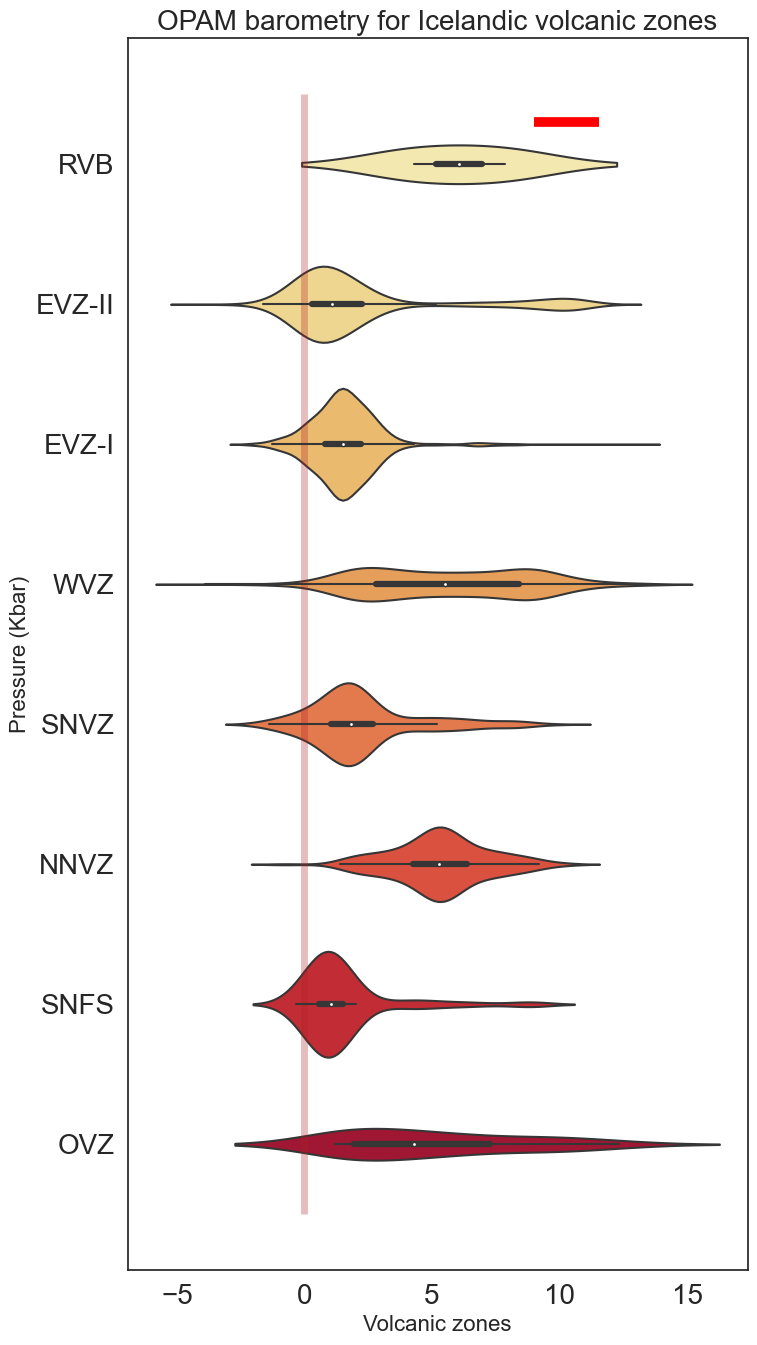

In [9]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8,16)})
sns.set_style("white")
b=sns.violinplot(y='Volcanic Zone specific', x='Pressure_min', data=df_up,  palette="YlOrRd", order=["RVB", "EVZ-II", "EVZ-I", "WVZ", "SNVZ", "NNVZ","SNFS", "OVZ"])

plt.vlines( x = 0, color='firebrick', linewidth=5, alpha=.3, ymin = -0.5, ymax = 7.5) 
plt.hlines( y = -0.3, color='red', linewidth=7, xmin = 9, xmax = 11.56) 

b.axes.set_title("OPAM barometry for Icelandic volcanic zones",fontsize=20)
b.set_xlabel("Volcanic zones",fontsize=16)
b.set_ylabel("Pressure (Kbar)",fontsize=16)
b.tick_params(labelsize=20)
plt.show()

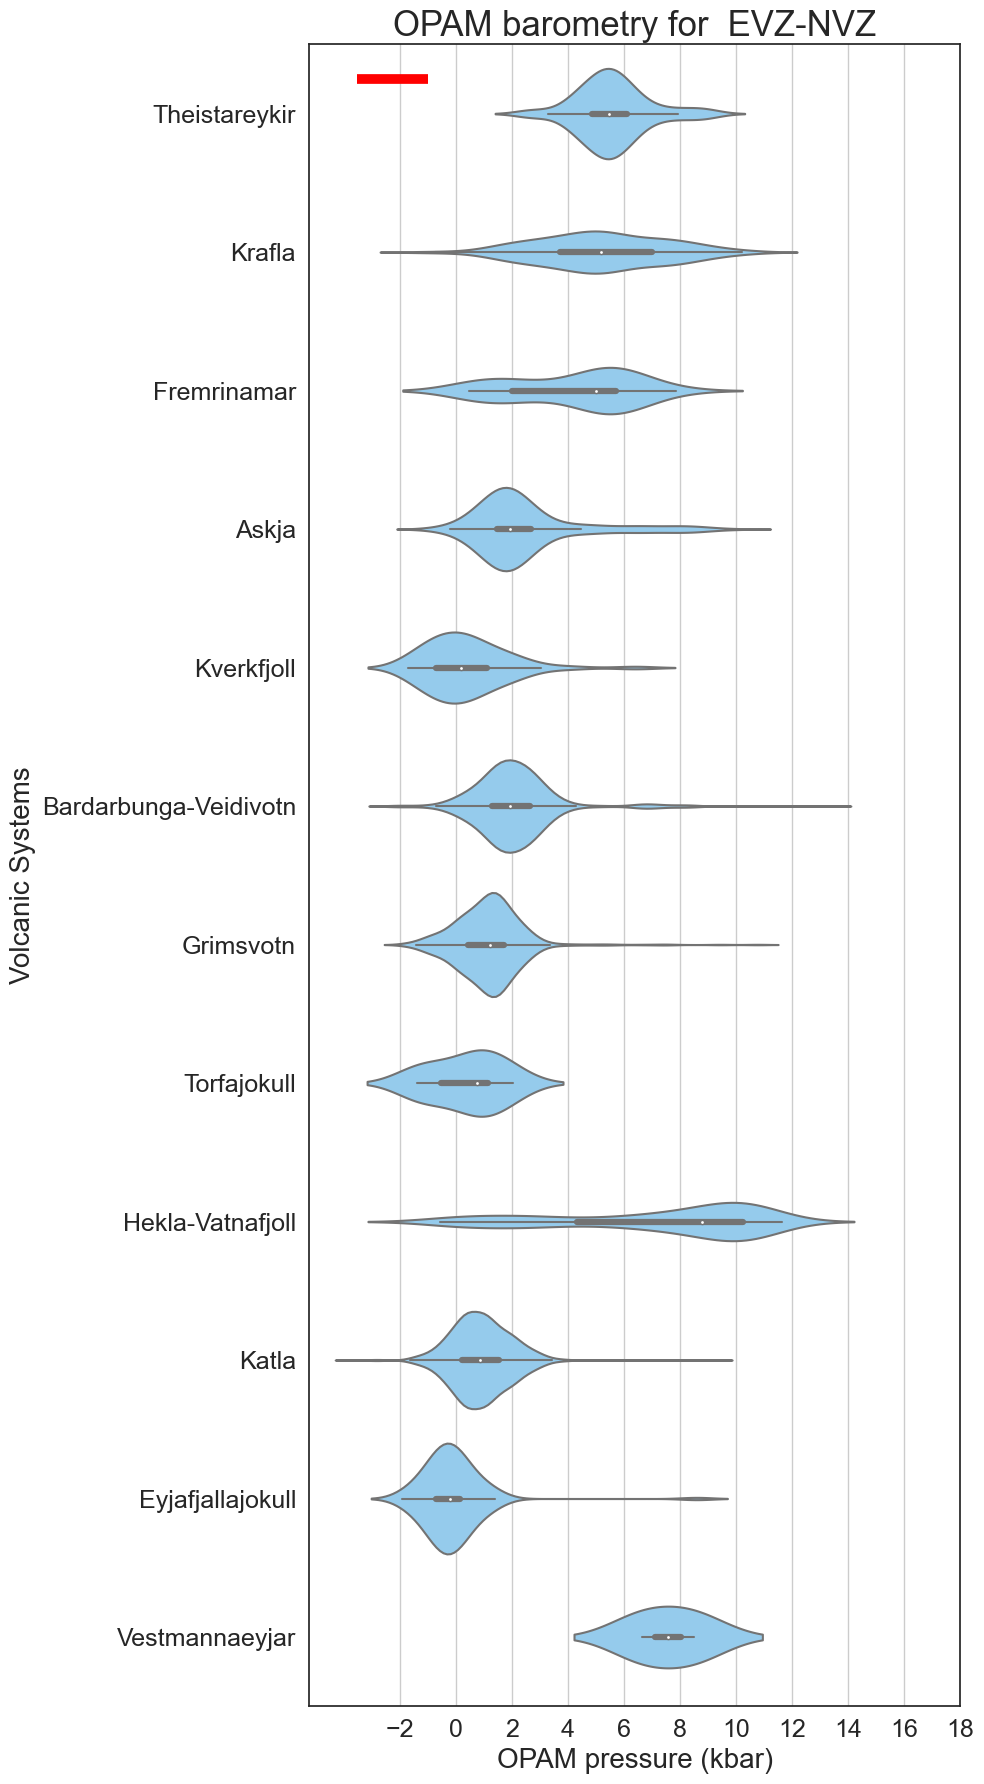

In [10]:
import seaborn as sns
import matplotlib.axes as ax
import matplotlib

sns.set(rc={'figure.figsize':(10, 18)})
sns.set_style("white")
#plt.style.use("dark_background")
plt.hlines(  y = -0.25, color='red', linewidth=7, xmin = -3.52, xmax = -1) 
#plt.vlines( x = 0, color='gold', linewidth=7, alpha=.5, ymin = -0.5, ymax = 11) 
b=sns.violinplot( 
    x='Pressure_min', 
    y='Volcanic System',  
    dodge=False, 
    color = "lightskyblue",
    edgecolor="black",
    bw = "silverman",
    order = ['Theistareykir', 'Krafla', 'Fremrinamar', 'Askja','Kverkfjoll','Bardarbunga-Veidivotn', 'Grimsvotn','Torfajokull', 'Hekla-Vatnafjoll', 'Katla',  'Eyjafjallajokull', 'Vestmannaeyjar'],
    data=df_up,
)

b.axes.set_title("OPAM barometry for  EVZ-NVZ",fontsize=25)
b.set_ylabel("Volcanic Systems",fontsize=20)
b.set_xlabel("OPAM pressure (kbar)",fontsize=20)
b.tick_params(labelsize=18)
b.set(xticks=[-2,0,2,4,6,8,10,12,14,16,18])
b.grid(axis = 'x')
plt.tight_layout()
plt.show()

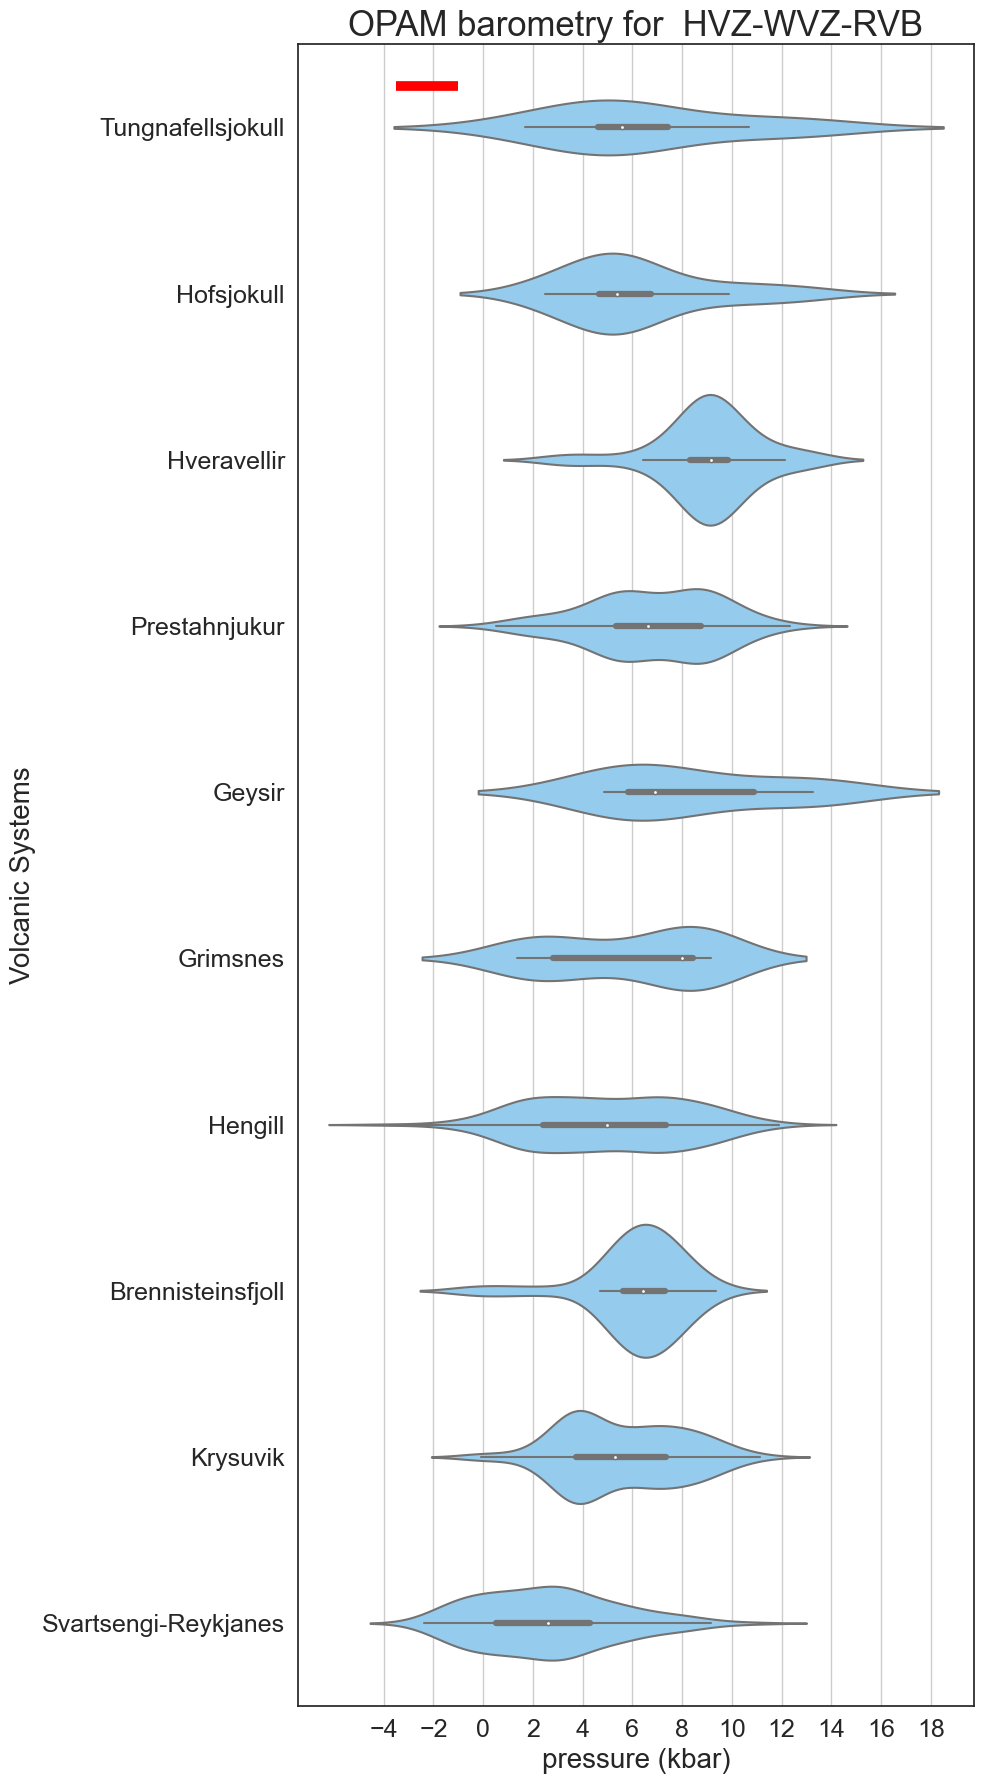

In [11]:
import seaborn as sns
import matplotlib.axes as ax
import matplotlib

sns.set(rc={'figure.figsize':(10, 18)})
sns.set_style("white")
#plt.style.use("dark_background")
plt.hlines(  y = -0.25, color='red', linewidth=7, xmin = -3.52, xmax = -1) 
#plt.vlines( x = 0, color='gold', linewidth=7, alpha=.5, ymin = -0.5, ymax = 11) 
b=sns.violinplot( 
    x='Pressure_min', 
    y='Volcanic Sys',  
    dodge=False, 
    color = "lightskyblue",
    edgecolor="black",
    bw = "silverman",  
    order = ['Tungnafellsjokull', 'Hofsjokull', 'Hveravellir','Prestahnjukur', 'Geysir', 'Grimsnes', 'Hengill', 'Brennisteinsfjoll', 'Krysuvik', 'Svartsengi-Reykjanes'],
    data=df_up
)
b.axes.set_title("OPAM barometry for  HVZ-WVZ-RVB",fontsize=25)
b.set_ylabel("Volcanic Systems",fontsize=20)
b.set_xlabel("pressure (kbar)",fontsize=20)
b.tick_params(labelsize=18)
b.set(xticks=[-4,-2,0,2,4,6,8,10,12,14,16, 18])
b.grid(axis = 'x')
plt.tight_layout()
plt.show()

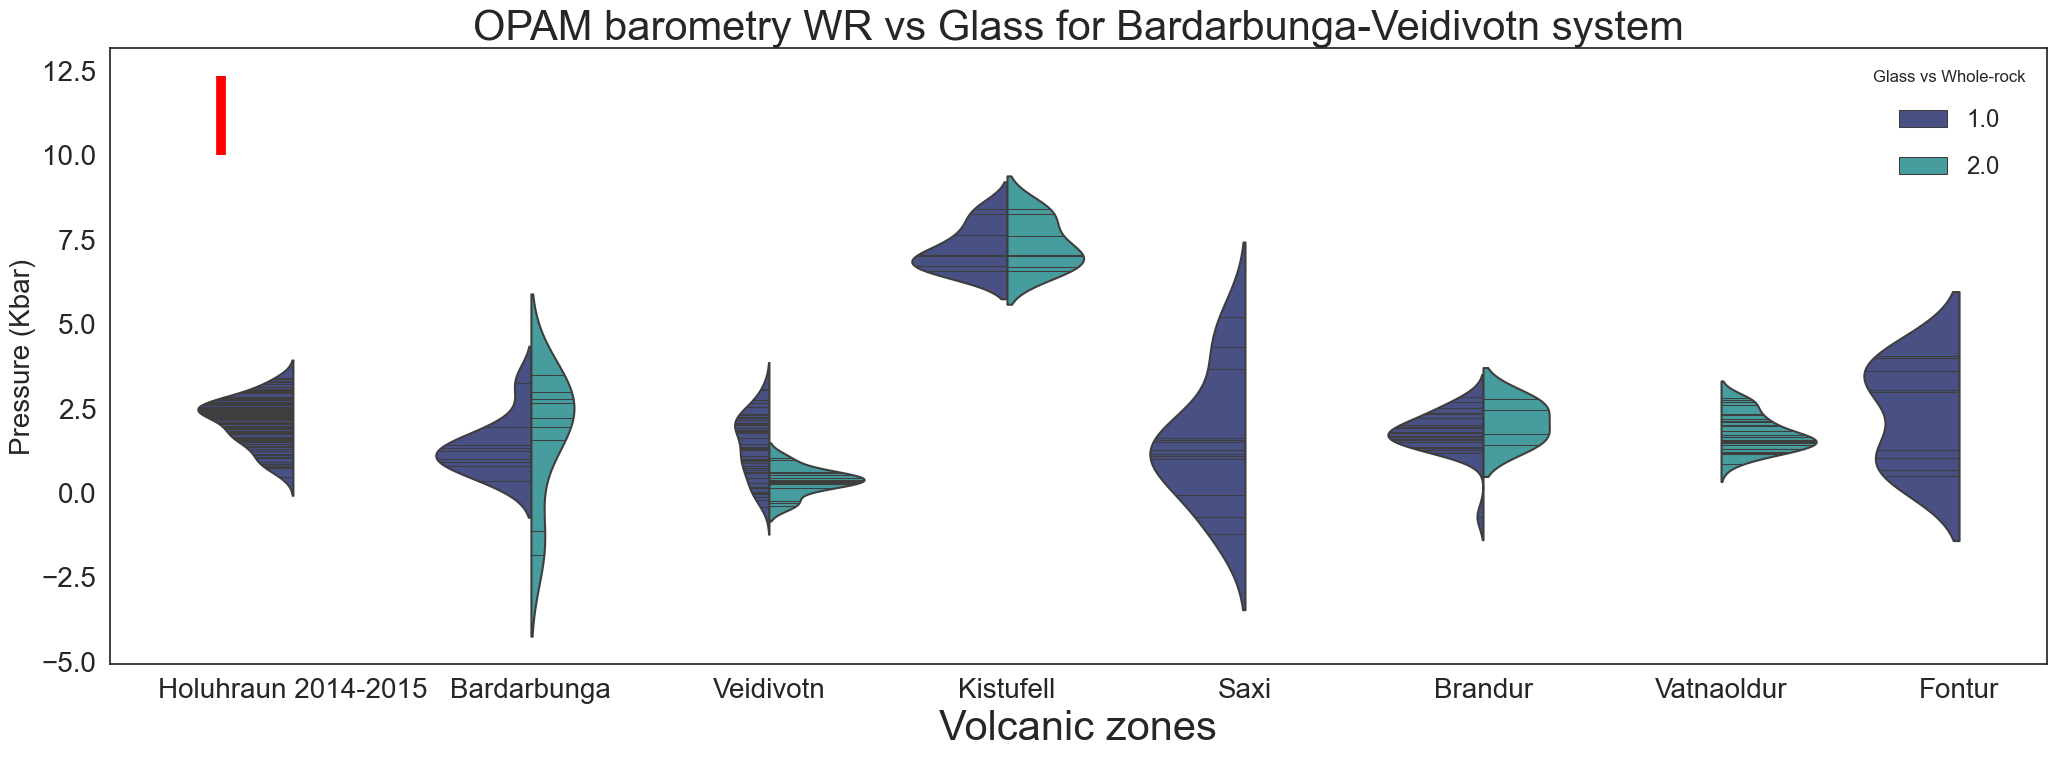

In [12]:
import seaborn as sns
sns.set(rc={'figure.figsize':(25,8)})
sns.set_style("white")
b=sns.violinplot(
    x='Systems', 
    y='Pressure_min', 
    data=df_up,  
    palette="mako",
    hue = 'TS',
    split=True, 
    inner="stick",
    order=["Holuhraun 2014-2015", "Bardarbunga", "Veidivotn", "Kistufell", "Saxi", "Brandur", "Vatnaoldur", "Fontur"]
)

#plt.hlines( y = 0, color='firebrick', linewidth=5, alpha=.3, xmin = -0.5, xmax = 7.5) 
plt.vlines( x = -0.3, color='red', linewidth=7, ymin = 10, ymax = 12.32) 

plt.legend(fontsize = 'x-large', markerscale = 5.0, frameon=False, loc='upper right', labelspacing=1, title='Glass vs Whole-rock')
b.axes.set_title("OPAM barometry WR vs Glass for Bardarbunga-Veidivotn system",fontsize=30)
b.set_xlabel("Volcanic zones",fontsize=30)
b.set_ylabel("Pressure (Kbar)",fontsize=20)
b.tick_params(labelsize=20)
plt.show()

# Pressure to depth calculation

In [13]:
rhoU = 3000 #density of upper icelandic in kg/m3
rhoL = 3050 #density of lower icelandic in kg/m3
''' densities from Darbyshire, F. A., White, R. S., & Priestley, K. F. (2000). 
Structure of the crust and uppermost mantle of Iceland from a combined seismic and gravity study. 
Earth and Planetary Science Letters, 181(3), 409-428.'''

g = 9.8 #gravity in m/s2
Ptr = 284200000 #Pressure in Pa = to 10 km depth with crustal density of 2900 kg/m3

cov = 1000*100000
P = cov*df_up.Pressure_min
df_up.append(P)

df_up.loc[:,('Pressure(Pa)')] = P

depth = []

for P in df_up["Pressure(Pa)"]:
    Ptr = 284200000
    D = P/(rhoU*g)
    if P <= Ptr:
        Z = D
    else:
        Z = D +((P-Ptr)/(rhoL*g))
    Dep = Z/1000
    depth.append(Dep)
df_up.loc[:,('Depth_km')] = depth
df_up

,Sample#,Reference,Volcanic Zone,Volcanic Zone specific,Volcanic System,Volcanic Sys,Location/Volcano/phase,Eruption,Systems,Comparison,Age yrs BP (Ref 1950),age error,Eruption type,Latitiude,Longitude,Type,Type Simplified,TS,Composition,SiO2,TiO2,Al2O3,Cr2O3,FeO,Fe2O3,MnO,MgO,CaO,Na2O,K2O,P2O5,SrO,BaO,H2O,sum,Pressure_min,Probability,Pressure(Pa),Depth_km
Ex_row,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ExRow_13,DICE5,Burnard2005,WVZ,WVZ,Hromundartindur,Hromundartindur,SW_of_Maelifell,Maelifell,Maelifell-Midfell,Maelifell-Midfell,0,0.0,0,64.096389,-21.201944,Glass,glass,1.0,Pillow rim,48.381,1.031,15.216,0.0,9.330,0.0,0.165,9.175,14.794,1.876,0.031,0.000,0.0,0.0,0.0,100.0,3.808926,0.989194,3.808926e+08,16.190480
ExRow_15,DICE8,Burnard2005,WVZ,WVZ,Hengill,Hengill,Olfusvatnsfjoll,Olfusvatnsfjoll,Hengill,Hengill,0,0.0,0,64.130278,-21.131111,Glass,glass,1.0,Pillow rim,49.394,1.367,14.296,0.0,11.313,0.0,0.186,7.645,13.333,2.321,0.145,0.000,0.0,0.0,0.0,100.0,1.390495,0.939862,1.390495e+08,4.729575
ExRow_17,DICE43,Burnard2005,WVZ,WVZ,Hengill,Hengill,Hromundartindar,Hromundartindar,Hengill,Hengill,0,0.0,0,64.084167,-21.189167,Glass,glass,1.0,Pillow rim,48.560,2.464,14.721,0.0,12.538,0.0,0.250,6.893,11.436,2.755,0.385,0.000,0.0,0.0,0.0,100.0,4.007887,0.806474,4.007887e+08,17.532862
ExRow_19,Krysuvik,Condomines1983,RVB,REP,Krysuvik,Krysuvik,Krysuvik,0,Krysuvik,Krysuvik,0,0.0,0,63.900000,-22.080000,Glass,glass,1.0,0,49.314,1.543,14.825,0.0,10.488,0.0,0.182,8.441,12.707,2.037,0.252,0.212,0.0,0.0,0.0,100.0,4.362081,0.967256,4.362081e+08,19.922591
ExRow_20,HEN_1,Condomines1983,WVZ,WVZ,Hengill,Hengill,Hengill,0,Hengill,Hengill,0,0.0,0,64.170000,-21.400000,Glass,glass,1.0,0,48.834,0.951,15.011,0.0,9.156,0.0,0.150,9.006,15.211,1.621,0.010,0.050,0.0,0.0,0.0,100.0,2.145841,0.906451,2.145841e+08,7.298777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ExRow_13555,s_SK38 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,65.289700,-18.796100,whole-rock,whole-rock,2.0,0,48.890,2.874,12.990,0.0,14.090,0.0,0.234,6.110,10.340,2.330,0.390,0.323,0.0,0.0,0.0,0.0,1.994176,0.923234,1.994176e+08,6.782910
ExRow_13556,s_SK39 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,65.288200,-18.790100,whole-rock,whole-rock,2.0,0,48.190,3.648,12.420,0.0,15.460,0.0,0.255,5.280,9.480,2.630,0.471,0.407,0.0,0.0,0.0,0.0,1.503008,0.908336,1.503008e+08,5.112272
ExRow_13557,s_SK40 [17609],"Walters et al., 2013",SKA,0,Skagi,Skagi,Hunafloi Rift,0,0,0,0,0.0,0,66.033100,-20.005700,whole-rock,whole-rock,2.0,0,48.320,3.552,12.620,0.0,15.120,0.0,0.249,5.450,9.670,2.510,0.498,0.365,0.0,0.0,0.0,0.0,1.623798,0.856252,1.623798e+08,5.523121


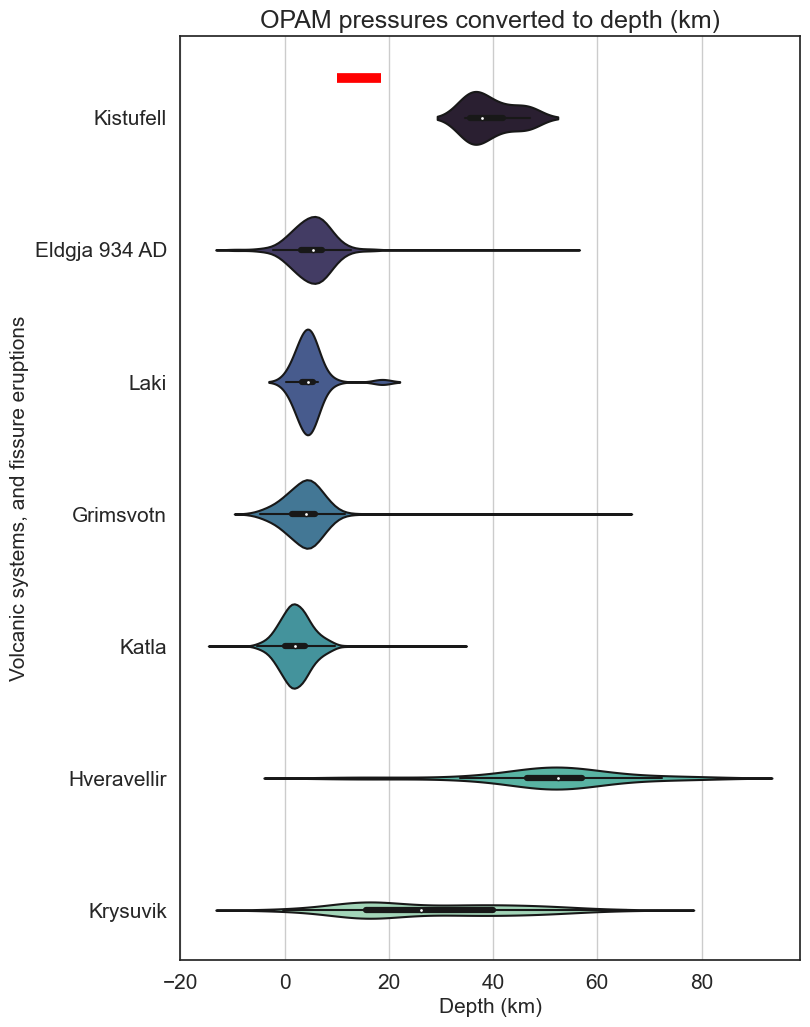

In [14]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8,12)})
sns.set_style("white")
b=sns.violinplot(
    y='Systems', 
    x='Depth_km', 
    data=df_up, 
    bw = "silverman",
    palette="mako",
    order=[ "Kistufell", "Eldgja 934 AD", "Laki", "Grimsvotn", "Katla", "Hveravellir", "Krysuvik"]
)

#plt.hlines( y = 0, color='firebrick', linewidth=5, alpha=.3, xmin = -0.5, xmax = 7.5) 
plt.hlines( y = -0.3, color='red', linewidth=7, xmin = 10, xmax = 18.57) 
b.grid(axis = 'x')
b.axes.set_title("OPAM pressures converted to depth (km)",fontsize=18)
b.set_ylabel("Volcanic systems, and fissure eruptions",fontsize=15)
b.set_xlabel("Depth (km)",fontsize=15)
b.tick_params(labelsize=15)
plt.show()

# Magma Flux Calcuations
## Comparison of magma flux to OPAM median pressures

In [16]:
bm = pd.read_csv('45.2.csv')
index = bm.index
columns = bm.columns
data = bm.values
bm.fillna(0, inplace=True)
bm

,Unnamed: 0,Longitude,Latitude,Pressure,Crust km,System,Z,Zone,Type,Volc system area km2,Volc system length km,Volc system width km,blockmedian length km,blockmedian with km,blockmedian area km2,spreading rate (mm/yr),References,Spreading rate (km/yr),Spreading rate x volc sys length,Spreading rate x block length,Annual volume - crustal thickness x spreading rate x system length,Annual volume = crustal thickness x spreading rate x block length,Area 1 (block length x volc sys width),flux 1 (block),flux 2 (block and width),flux 3 (length volume/volc area),flux 4 (length volume / block and width
0,0,-16.910000,66.100000,5.048216,17.127514,Theistareykir,NVZ,NNVZ,rift,650,90,9,45,45,2025,17.0,"Drouin et al., 2017; Sigmundsson et al., 2020",1.700000e-05,0.001530,0.000765,0.026205,0.013103,405,6.470000e-06,3.240000e-05,4.030000e-05,6.470000e-05
1,1,-16.170000,66.150000,2.065563,27.047031,Fremrinamur,NVZ,NNVZ,rift,1200,150,15,45,45,2025,17.0,"Drouin et al., 2017; Sigmundsson et al., 2020",1.700000e-05,0.002550,0.000765,0.068970,0.020691,675,1.020000e-05,3.070000e-05,5.750000e-05,1.021780e-04
2,2,-16.840000,65.785000,5.259803,18.260187,Krafla,NVZ,NNVZ,rift,900,100,19,45,45,2025,17.0,"Drouin et al., 2017; Sigmundsson et al., 2020",1.700000e-05,0.001700,0.000765,0.031042,0.013969,855,6.900000e-06,1.630000e-05,3.450000e-05,3.630000e-05
3,3,-16.405000,65.845000,3.349601,21.405642,Fremrinamur,NVZ,NNVZ,rift,1200,150,15,45,45,2025,17.0,"Drouin et al., 2017; Sigmundsson et al., 2020",1.700000e-05,0.002550,0.000765,0.054584,0.016375,675,8.090000e-06,2.430000e-05,4.550000e-05,8.090000e-05
4,4,-17.040000,65.410000,4.871955,27.315809,Krafla,NVZ,NNVZ,rift,900,100,19,45,45,2025,17.0,"Drouin et al., 2017; Sigmundsson et al., 2020",1.700000e-05,0.001700,0.000765,0.046437,0.020897,855,1.030000e-05,2.440000e-05,5.160000e-05,5.430000e-05
5,5,-16.300000,65.600000,1.933770,21.522394,askja,NVZ,SNVZ,rift,2300,200,20,45,45,2025,17.0,"Drouin et al., 2017; Sigmundsson et al., 2020",1.700000e-05,0.003400,0.000765,0.073176,0.016465,900,8.130000e-06,1.830000e-05,3.180000e-05,8.130000e-05
6,6,-22.921900,64.902100,2.786347,27.914596,Ljosufjoll,SNFS,SNFS,flank,720,80,15,45,45,2025,0.5,estimated for calc,5.000000e-07,0.000040,0.000023,0.001117,0.000628,675,3.100000e-07,9.300000e-07,1.550000e-06,1.650000e-06
7,7,-20.550000,64.810000,8.758081,25.064173,Hveravellir,WVZ,WVZ,rift,720,60,18,45,45,2025,2.6,"Sigmundsson et al., 1995; La Femina et al., 20...",2.600000e-06,0.000156,0.000117,0.003910,0.002933,810,1.450000e-06,3.620000e-06,5.430000e-06,4.830000e-06
8,8,-19.800000,64.950000,9.165561,26.359779,Hveravellir,WVZ,WVZ,rift,720,60,18,45,45,2025,1.3,"Sigmundsson et al., 1995; La Femina et al., 20...",1.300000e-06,0.000078,0.000058,0.002056,0.001542,810,7.620000e-07,1.900000e-06,2.860000e-06,2.540000e-06
9,9,-18.830000,65.010000,7.203559,30.500994,hofsjokull,HVZ,HVZ,rift,2200,95,38,45,45,2025,1.0,Einarsson 2008,1.000000e-06,0.000095,0.000045,0.002898,0.001373,1710,6.780000e-07,8.030000e-07,1.320000e-06,1.690000e-06


In [33]:
def linear_regression(x, y):     
    N = len(x)
    x_mean = x.mean()
    y_mean = y.mean()
    
    B1_num = ((x - x_mean) * (y - y_mean)).sum()
    B1_den = ((x - x_mean)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean - (B1*x_mean)
    
    reg_line = 'y = {} + {}β'.format(B0, round(B1, 3))
    
    return (B0, B1, reg_line)

def corr_coef(x, y):
    N = len(x)
    
    num = (N * (x*y).sum()) - (x.sum() * y.sum())
    den = np.sqrt((N * (x**2).sum() - x.sum()**2) * (N * (y**2).sum() - y.sum()**2))
    R = num / den
    return R

Regression Line:  y = 1.3750452650052412e-05 + -0.0β
Correlation Coef.:  -0.8204390772734145
"Goodness of Fit":  0.6731202795172517


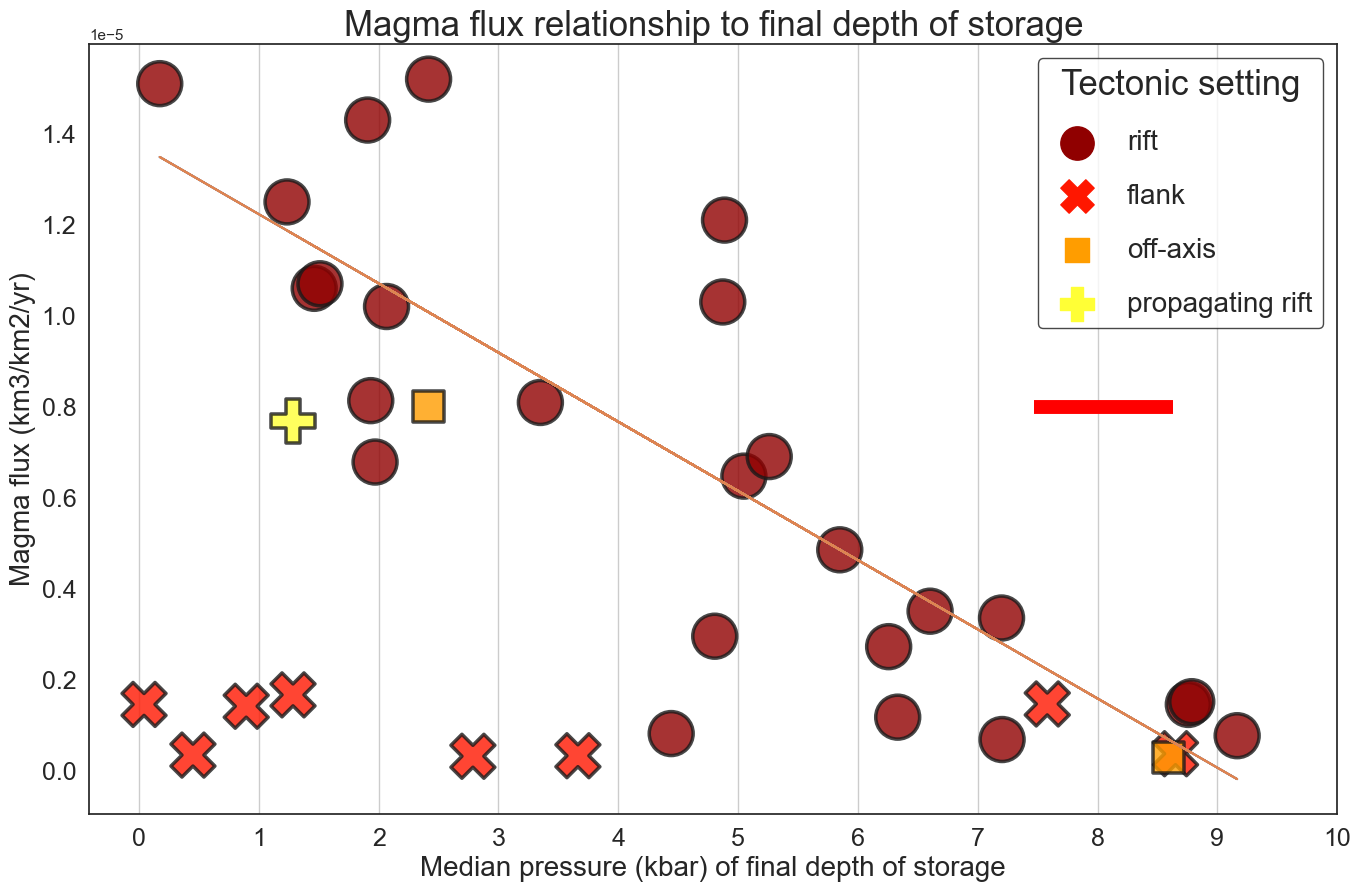

In [35]:
rift =bm.loc[bm['Type']=="rift"]

#line of fit for rift zone volcanic systems
x = rift['Pressure']
y = rift['flux 1 (block)']
#plt.plot(x, y, 'o')
B0, B1, reg_line = linear_regression(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)


B0, B1, reg_line = linear_regression(x, y)
print('Regression Line: ', reg_line)
R = corr_coef(x, y)
print('Correlation Coef.: ', R)
print('"Goodness of Fit": ', R**2)

#----------------------------------------
#figure
sns.set(rc={'figure.figsize':(16.1,10)})
sns.set_style("white")

ax = sns.scatterplot(x="Pressure", 
                     y="flux 1 (block)", 
                     data=bm,
                     hue = "Type",
                     palette = "hot",
                     s = 1000,
                     style = 'Type',
                     edgecolor = "k",
                     alpha = 0.8
)

ax.axes.set_title("Magma flux relationship to final depth of storage",fontsize=25)
plt.hlines(  y = 0.000008, color='red', linewidth=10, xmin = 7.47, xmax = 8.63) 
ax.set_xlabel("Median pressure (kbar) of final depth of storage",fontsize=20)
ax.set_ylabel("Magma flux (km3/km2/yr)",fontsize=20)
ax.tick_params(labelsize=18)
ax.set(xticks=[0,1,2,3,4,5,6,7,8,9,10])
ax.grid(axis = 'x')

#legend and annotation
ax.legend(title = "Tectonic setting", title_fontsize = 25, fontsize = 20, edgecolor = 'k',labelspacing=1, ncol=1, markerscale=4)
plt.savefig("Magma flux by block", bbox_inches='tight', facecolor = "white", dpi=500)

plt.show()

# CSV output file

In [15]:
#turn dataframe back to csv file
df_up.to_csv('Icelandic_OPAM_output.csv')

#or Excel
#writer = pd.ExcelWriter('myDataFrame.xlsx')
#df.to_excel(writer, 'DataFrame')
#writer.save()